In [1]:
import os
import numpy as np
import imageio
import math as m
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import cv2
# %matplotlib inline
%matplotlib notebook

import scipy.io as sio

In [18]:
def fig2data(fig):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw()

    # Get the RGBA buffer from the figure
    w, h = fig.canvas.get_width_height()
    buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w, h, 4)

    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll(buf, 3, axis=2)[:,:,:3]
    return buf

def show_images(images, step, path_to_save, cols = 1, titles = None):
  """Display a list of images in a single figure with matplotlib.
  
  Parameters
  ---------
  images: List of np.arrays compatible with plt.imshow.
  
  cols (Default = 1): Number of columns in figure (number of rows is 
                      set to np.ceil(n_images/float(cols))).
  
  titles: List of titles corresponding to each image. Must have
          the same length as titles.
  """
  assert((titles is None) or (len(images) == len(titles)))
  n_images = len(images)
  if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
  fig = plt.figure()
  for n, (image, title) in enumerate(zip(images, titles)):
      a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
      if image.ndim == 2:
          plt.gray()
      plt.imshow(image)
      a.set_title(title)
  fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
  fig_img = fig2data(fig)
  plt.savefig(path_to_save+"/results_"+str(step)+".jpg")
  # plt.show()
  plt.close(fig)
  return fig_img



limb_parents = [0, 0, 1, 2, 3, 1, 5, 6, 1, 0, 9, 10, 11, 0, 13, 14, 15]
# limb_parents = [0, 0, 1, 2, 3, 1, 5, 6, 1, 0, 9, 10, 0, 12, 13]

def get_figure():           
    fig = plt.figure(frameon=False, figsize=(8, 8))
    fig.clf()
    return fig


def fig2rgb_array(fig, expand=True):
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    shape = (nrows, ncols, 3) if not expand else (1, nrows, ncols, 3)
    return np.fromstring(buf, dtype=np.uint8).reshape(shape)


def figure_to_summary(fig, iteration_no,  train_writer, vis_summary, vis_placeholder, mode=None):
    image = fig2rgb_array(fig)

    # print(" gg", vis_placeholder)

    # if mode=='test':
    #     test_writer.add_summary(vis_summary.eval(feed_dict={vis_placeholder: image}), global_step= iteration_no )
    # else:    
    train_writer.add_summary(vis_summary.eval(feed_dict={vis_placeholder: image}), global_step= iteration_no )
    plt.close(fig)

def draw_limbs_3d_plt(joints_3d, ax, limb_parents=limb_parents, z_flip = True):
    for i in range(joints_3d.shape[0]):
#         plt.text(i, (joints_3d[i, 0], joints_3d[i, 0]), str(i))
#         ax.text(joints_3d[i, 0], joints_3d[i, 1], joints_3d[i, 2], s=str(i))
        x_pair = [joints_3d[i, 0], joints_3d[limb_parents[i], 0]]
        y_pair = [joints_3d[i, 1], joints_3d[limb_parents[i], 1]]
        z_pair = [joints_3d[i, 2], joints_3d[limb_parents[i], 2]]
        ax.scatter(x_pair[0], y_pair[0], z_pair[0], c='black', s=80)
        ax.scatter(x_pair[1], y_pair[1], z_pair[1], c='black', s=80)
        ax.plot(x_pair, y_pair, z_pair, color=clrs[i]/255.0, linewidth=5, antialiased=True)
#         if z_flip:
#             ax.plot(z_pair, x_pair, y_pair, linewidth=3, antialiased=True)
#         else:
#             ax.plot(x_pair, y_pair,z_pair, linewidth=3, antialiased=True)
#         dist = np.sqrt(np.square(x_pair[0]-x_pair[1]) + np.square(y_pair[0]-y_pair[1]) + np.square(z_pair[0]-z_pair[1]))
#         print ("distance ", i, "<->", limb_parents[i], " = ", dist)
#     ax.view_init(50, 210)    

def get_ax(joints_3d, fig, az=0, ele=10, subplot='111'):
    ax = fig.add_subplot(subplot, projection='3d')

    lim = np.max(np.abs(joints_3d))
#     print("lim", lim)
    ax.view_init(azim=az, elev=ele)
    
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    grid = False
    if grid == False:
        ax.axis('off')
        ax.grid(False)
    
    return ax

def get_skeleton_plot(joints_3d, ax, limb_parents=limb_parents, title="", z_flip=True):
#     fig = plt.figure(frameon=False, figsize=(7, 7))
    draw_limbs_3d_plt(joints_3d, ax, limb_parents, z_flip=False)
    plt.title(title)


def plot_skeleton(joints_3d, ax, limb_parents=limb_parents, title="", z_flip=True):
    get_skeleton_plot(joints_3d, ax, limb_parents, title, z_flip=z_flip)

In [170]:
limb_parents = [0, 0, 1, 2, 3, 1, 5, 6, 1, 0, 9, 10, 11, 0, 13, 14, 15]

clrs = np.array([[175,25,240],                               #1
   [25,128,128],[75,180,80],[170,170,70],[60,128,210],     #5
   [200,130,0],[180,30,145],[255,128,50],[240,50,128],     #9
   [200,20,110],[0,0,255],[128,128,0], [0,128,255],        #13
   [0,255,0],[255,0,128],[128,255,0],[255,0,0]])           #17

def draw_limbs_3d_plt(joints_3d, ax, limb_parents=limb_parents, z_flip = True):
    #     depth = np.stack([joints_3d[:,2], np.arange(17)],1)
    list1 = joints_3d[:,2]
    list2 = np.arange(17)
    list1, list2 = zip(*sorted(zip(list1, list2)))
    
    
    for i in list2[::-1]:
#     for i in range(joints_3d.shape[0]):

#         plt.text(i, (joints_3d[i, 0], joints_3d[i, 0]), str(i))
#         ax.text(joints_3d[i, 0], joints_3d[i, 1], joints_3d[i, 2], s=str(i))
        x_pair = [joints_3d[i, 0], joints_3d[limb_parents[i], 0]]
        y_pair = [joints_3d[i, 1], joints_3d[limb_parents[i], 1]]
        z_pair = [joints_3d[i, 2], joints_3d[limb_parents[i], 2]]
        ax.scatter(x_pair[0], y_pair[0], z_pair[0], c='black', s=80)
        ax.scatter(x_pair[1], y_pair[1], z_pair[1], c='black', s=80)
        ax.plot(x_pair, y_pair, z_pair, color=clrs[i]/255.0, linewidth=5, antialiased=True)
#         if z_flip:
#             ax.plot(z_pair, x_pair, y_pair, linewidth=3, antialiased=True)
#         else:
#             ax.plot(x_pair, y_pair,z_pair, linewidth=3, antialiased=True)
            
        dist = np.sqrt(np.square(x_pair[0]-x_pair[1]) + np.square(y_pair[0]-y_pair[1]) + np.square(z_pair[0]-z_pair[1]))
#         print ("distance ", i, "<->", limb_parents[i], " = ", dist)
    # ax.view_init(10, 210)   

def get_skeleton_plot(joints_3d, ax, limb_parents=limb_parents, title="", z_flip=True):
#     fig = plt.figure(frameon=False, figsize=(7, 7))
    draw_limbs_3d_plt(joints_3d, ax, limb_parents, z_flip=False)
    plt.title(title)


def plot_skeleton(joints_3d, ax, limb_parents=limb_parents, title="", z_flip=True):
    get_skeleton_plot(joints_3d, ax, limb_parents, title, z_flip=z_flip)

# def get_ax(joints_3d, fig, az=0, ele=10, subplot='111'):
#     ax = fig.add_subplot(subplot, projection='3d')

#     lim = np.max(np.abs(joints_3d))
# #     print("lim", lim)
#     ax.view_init(azim=az, elev=ele)
    
#     ax.set_xlim(-lim, lim)
#     ax.set_ylim(-lim, lim)
#     ax.set_zlim(-lim, lim)
#     ax.set_xlabel('x')
#     ax.set_ylabel('y')
#     ax.set_zlabel('z')
    
#     return ax

# def get_ax(joints_3d, fig, az=0, ele=10, subplot='111'):
#     ax = fig.add_subplot(subplot, projection='3d')

#     lim_max = np.max(joints_3d)
#     lim_min = np.min(joints_3d)
# #     print("lim", lim)
#     ax.view_init(azim=az, elev=ele)
    
#     ax.set_xlim(lim_min, lim_max)
#     ax.set_ylim(lim_min, lim_max)
#     ax.set_zlim(lim_min, lim_max)
#     ax.set_xlabel('x')
#     ax.set_ylabel('y')
#     ax.set_zlabel('z')
    
#     return ax

def get_ax(joints_3d, fig, az=0, ele=10, subplot='111'):
    ax = fig.add_subplot(subplot, projection='3d')

    lim_max_x = np.amax(joints_3d[:, 0])
    lim_min_x = np.amin(joints_3d[:, 0])
    lim_max_y = np.amax(joints_3d[:, 1])
    lim_min_y = np.amin(joints_3d[:, 1])
    lim_max_z = np.amax(joints_3d[:, 2])
    lim_min_z = np.amin(joints_3d[:, 2])
    print (lim_max_x, lim_min_x)
#     print("lim", lim)
    ax.view_init(azim=az, elev=ele)
    
    ax.set_xlim(lim_min_x-1.0, lim_max_x+1.0)
    ax.set_ylim(lim_min_y-1.0, lim_max_y+1.0)
    ax.set_zlim(lim_min_z-1.0, lim_max_z+1.0)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    grid = False
    if grid == False:
        ax.axis('off')
        ax.grid(False)
    
    return ax

def vis_3d(skeleton_3d):
    fig = plt.figure(frameon=False, figsize=(10, 10))
    # az = 90
    ax = get_ax(skeleton_3d, fig, az=90, ele=0, subplot='121')
    plot_skeleton(skeleton_3d, ax, z_flip=False)
    ax.set_title("pred_3d_front_view")

    ax = get_ax(skeleton_3d, fig, az=60, ele=40, subplot='122')
    plot_skeleton(skeleton_3d, ax, z_flip=False)
    ax.set_title("pred_3d_side_view")

    return fig

def skeleton_to_image(skltn):
    '''
    skltn: batch of 3d skeletons
    '''
    fig = vis_3d(skltn[0])
    fig.savefig("skeleton_3d.png", transparent=True)
#     plt.close(fig)
#     fig_img = cv2.imread("skeleton_3d.png")[:, :, ::-1]

In [40]:
pose_3d = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/poses_3d/S11_Photo_60457274.mat')['pose_3d'][446]

(0.7140031895760433, -4.81131358956876)
(0.7140031895760433, -4.81131358956876)


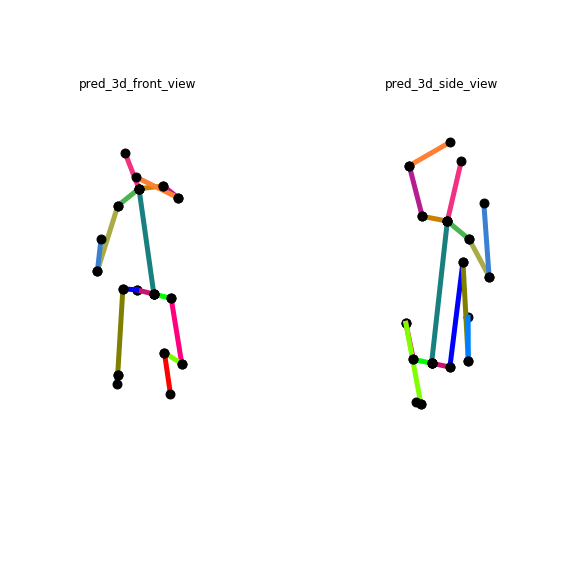

In [54]:
skeleton_images = skeleton_to_image(np.stack([pose_3d, pose_3d], 0)[0:1])

(0.71400319, -5.11131359)
(0.71400319, -5.11131359)


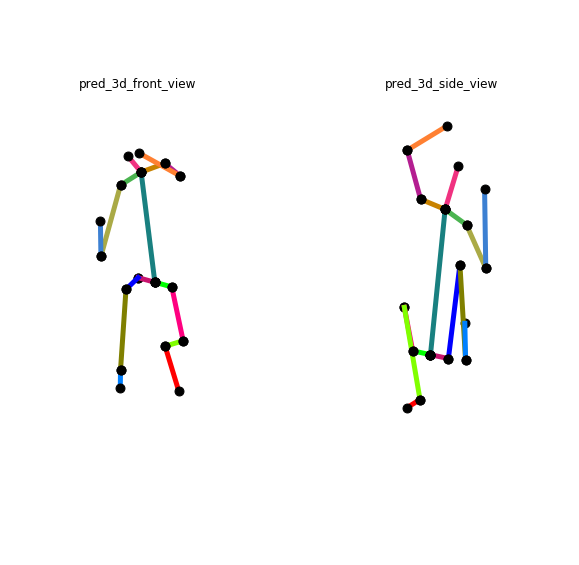

In [93]:
skeleton_images = skeleton_to_image(np.stack([pose_3d_, pose_3d_], 0)[0:1])

In [92]:
pose_3d_ = np.array([[ 0.        ,  0.        ,  0.        ],
       [-1.86385291, -1.60007866,  3.86550127],
       [-2.78606805, -0.82034226,  3.41863933],
       [-4.03051543, -0.7473125 ,  0.91144621],
       [-5.11131359, -2.68925706,  2.08584203],
       [-0.75390807, -2.39679408,  4.16633287],
       [-1.37035739, -5.07139541,  3.61271028],
       [-3.48071865, -4.20770463,  4.36131805],
       [-3.17415999, -2.40409017,  4.34482173],
       [-0.71400292,  0.75181936,  0.16573316],
       [-3.37010685, -2.50096404,  -0.23290489],
       [-2.94763569, -1.10973189, -3.06042036],
       [-3.92665825, -2.83676841, -3.60303054],
       [ 0.71400319, -0.75181906, -0.16573336],
       [-0.48151125, -3.95812898, -2.00095859],
       [ 0.41858173, -0.48520696, -2.30322502],
       [ 0.59948042, -1.71328403, -3.84918785]])

In [243]:
# gt
pose_770 = np.array([[[ 0.        ,  0.        ,  0.        ],
        [-0.03662527,  0.04847908,  0.4562378 ],
        [ 0.12935817,  0.06833506,  0.4440597 ],
        [ 0.2405013 ,  0.12362385,  0.2417204 ],
        [ 0.508649  ,  0.064394  ,  0.20265102],
        [-0.20260859,  0.0286231 ,  0.438416  ],
        [-0.2864027 ,  0.06161356,  0.21300018],
        [-0.367711  , -0.03191376,  0.08907272],
        [-0.05553436,  0.01361942,  0.65472925],
        [ 0.08396471, -0.00117207,  0.00568199],
        [ 0.07699833, -0.17037487, -0.32901335],
        [ 0.08824301, -0.0344286 , -0.6880628 ],
        [ 0.12024301, -0.0344286 , -0.6880628 ],
        [-0.08396471,  0.00117159, -0.00568199],
        [-0.0518856 , -0.20936394, -0.33248734],
        [-0.00934386, -0.09592009, -0.60000685],
        [-0.04934386, -0.09592009, -0.68508685]]])

In [184]:
pose_147.shape

(1, 17, 3)

(4.069192, -2.941688)
(4.069192, -2.941688)


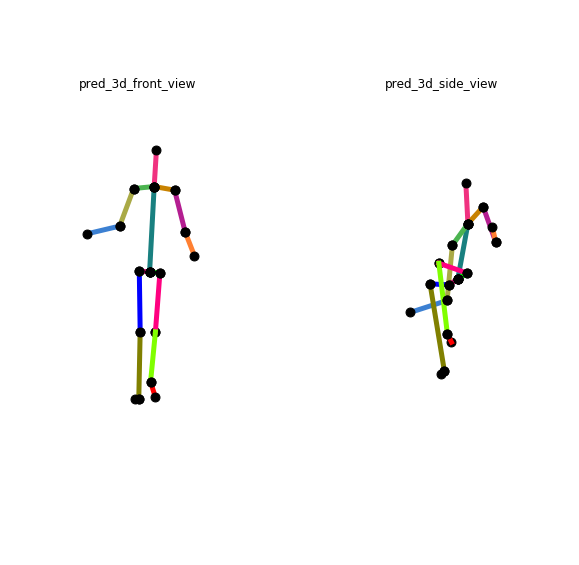

In [244]:
skeleton_images = skeleton_to_image(pose_770[0:1]*8)

(-0.5, 999.5, 1001.5, -0.5)

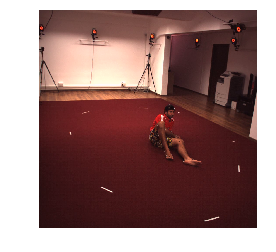

In [14]:
%matplotlib inline
image = cv2.imread('/data/vcl/sid/human36_parsed/parsed_data/extracted_frames/S9_SittingDown_60457274/1552.png')
image.shape
plt.imshow(image[:,:,::-1])
plt.axis('off')

In [387]:
poses_3d.shape

(1307, 17, 3)

<IPython.core.display.Javascript object>


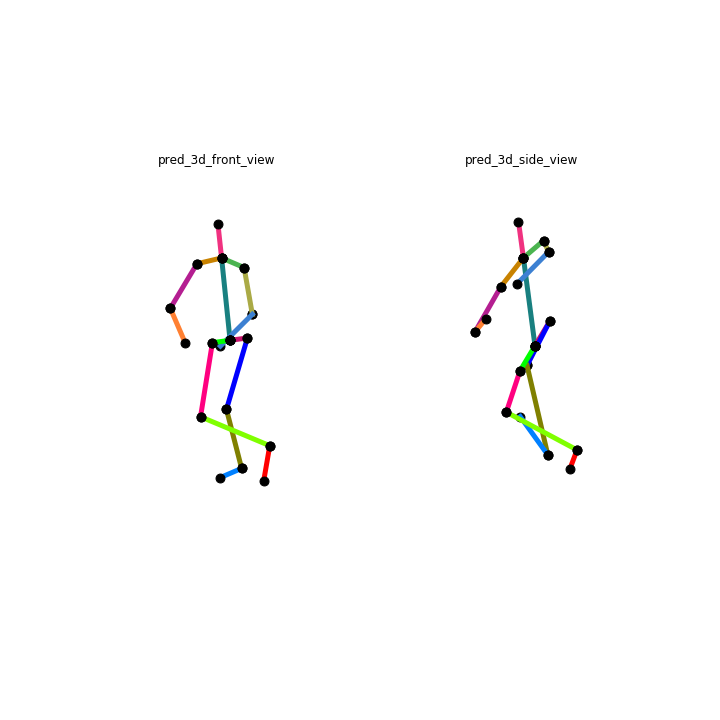

(2.608500794614222, -1.8662266344076968)
(2.608500794614222, -1.8662266344076968)


In [38]:
poses_3d = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/poses_3d/S9_Posing_54138969.mat')['pose_3d']
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
skeleton_images = skeleton_to_image(poses_3d[1115:1553])

<IPython.core.display.Javascript object>


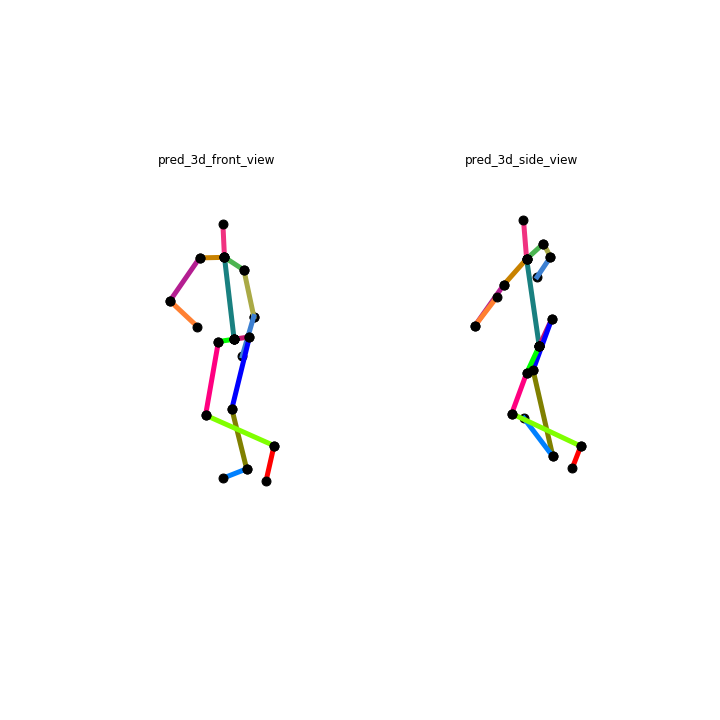

(2.8332048457108963, -1.7627008088241398)
(2.8332048457108963, -1.7627008088241398)


In [34]:
poses_3d = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/poses_3d/S9_Posing_54138969.mat')['pose_3d']
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
skeleton_images = skeleton_to_image(poses_3d[1119:1553])

In [644]:
poses_3d[97:98]

array([[[ 0.        ,  0.        ,  0.        ],
        [-1.9716308 ,  1.51936881,  4.04557665],
        [-2.62531481,  1.61369664,  2.84528523],
        [-2.69609794,  0.92386357,  0.13251541],
        [-2.97285075, -0.75504888,  1.82504632],
        [-0.76548999,  1.09712548,  4.53937307],
        [ 1.58567149, -0.30781708,  3.95784398],
        [ 0.01108375, -1.61274081,  5.21396798],
        [-2.79099834,  0.86535554,  5.74878053],
        [-0.90224816,  0.52939658, -0.09048493],
        [-1.52196842, -0.68688404, -4.0624628 ],
        [-0.64899233,  0.97628055, -7.13358577],
        [-1.5680415 , -0.74623958, -7.56749016],
        [ 0.90224806, -0.5293967 ,  0.09048515],
        [ 0.44755656, -2.25139411, -3.71319472],
        [ 0.48679197, -2.10435104, -7.30997647],
        [-0.30118758, -3.94190818, -7.26025731]]])

In [671]:
temp = np.array([[[ 0.        ,  0.        ,  0.        ],
        [-1.9716308 ,  1.51936881,  4.04557665],
        [-2.62531481,  1.61369664,  2.84528523],
        [-2.69609794,  0.92386357,  0.13251541],
        [-3.57285075, -0.75504888,  1.82504632],
        [-0.76548999,  1.09712548,  4.53937307],
        [ 1.58567149, -0.30781708,  3.95784398],
        [ 0.01108375, -1.61274081,  5.21396798],
        [-2.79099834,  0.86535554,  5.74878053],
        [-0.90224816,  0.52939658, -0.09048493],
        [-1.52196842, -0.68688404, -4.0624628 ],
        [-0.64899233,  0.97628055, -7.13358577],
        [-1.5680415 , -0.74623958, -7.56749016],
        [ 0.90224806, -0.5293967 ,  0.09048515],
        [ 0.44755656, -2.25139411, -3.71319472],
        [ 0.48679197, -2.10435104, -7.30997647],
        [ 0.70118758, -3.94190818, -7.86025731]]])

<IPython.core.display.Javascript object>


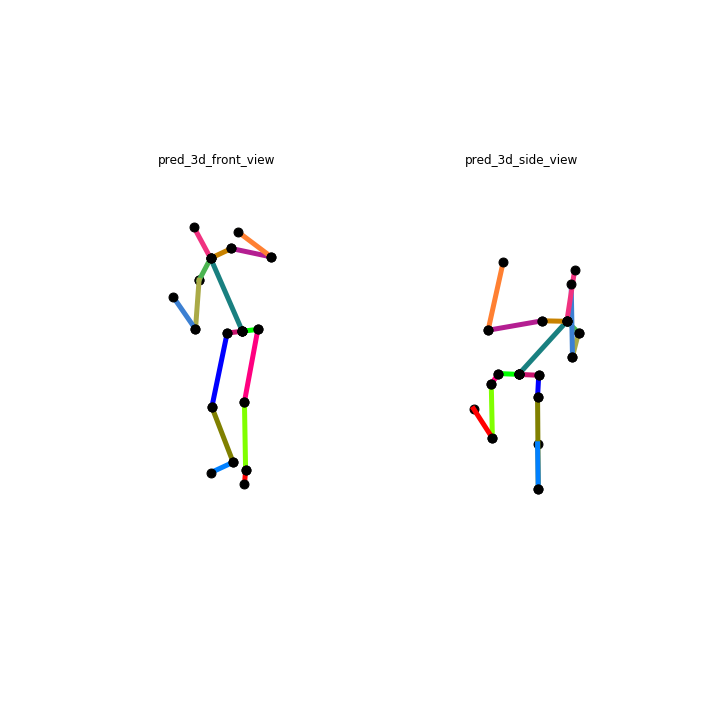

(1.58567149, -3.57285075)
(1.58567149, -3.57285075)


In [672]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
skeleton_images = skeleton_to_image(temp)

In [724]:
poses_3d[0:1]

array([[[ 0.        ,  0.        ,  0.        ],
        [-0.01743143,  0.0697519 ,  4.74945584],
        [-1.35398873,  0.36790132,  4.70918778],
        [-4.08885858,  0.72591983,  4.22720267],
        [-6.40351681,  0.1535547 ,  4.50061712],
        [ 1.34258562,  0.15410236,  4.89136643],
        [ 4.11325435,  0.0642801 ,  4.49725131],
        [ 6.40892919, -0.63340963,  4.55298363],
        [-0.2498014 , -0.12726547,  6.72611675],
        [-1.04263184,  0.08735209,  0.08825228],
        [-1.17682188,  0.06239881, -4.10952932],
        [-1.00506831,  0.97618333, -7.58738765],
        [-1.51297424, -0.89616878, -8.0735246 ],
        [ 1.04263183, -0.08735194, -0.08825253],
        [ 1.10820673,  0.01614434, -4.28646506],
        [ 0.9961253 ,  0.9233132 , -7.76848781],
        [ 1.1258689 , -1.070326  , -7.86105859]]])

(-0.5, 223.5, 223.5, -0.5)

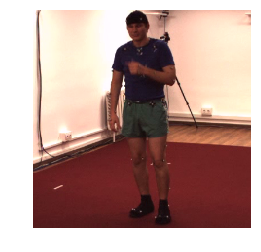

In [741]:
%matplotlib inline
image = cv2.imread('/data/vcl/sid/human36_parsed/parsed_data/center_crops/S11_Discussion 1_55011271_video_45_135_1/crop_params_231_616_327_712_1.png')
plt.imshow(image[:,:,::-1])
plt.axis('off')

<IPython.core.display.Javascript object>


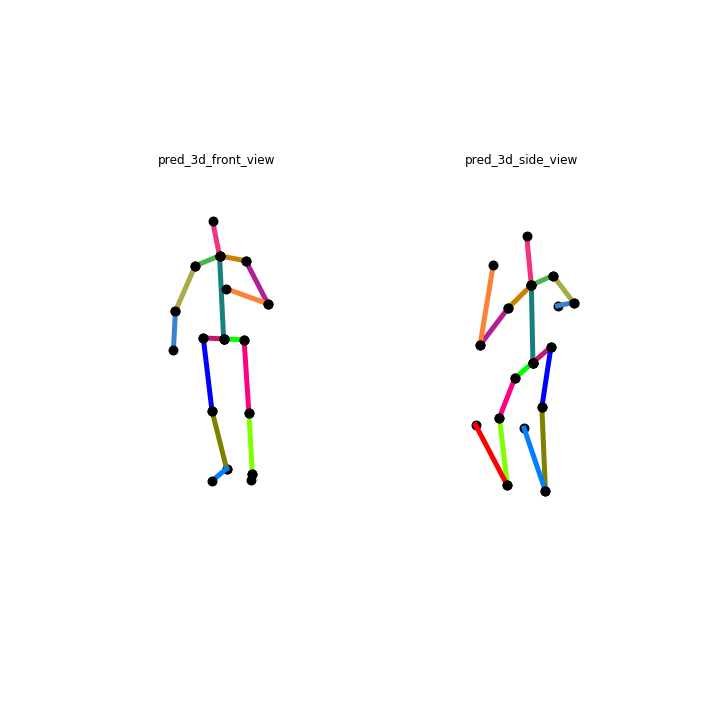

(2.414164701026918, -2.4591907364944037)
(2.414164701026918, -2.4591907364944037)


In [743]:
poses_3d = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/poses_3d/S11_Discussion 1_55011271.mat')['pose_3d']
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
skeleton_images = skeleton_to_image(poses_3d[46:47])

<IPython.core.display.Javascript object>


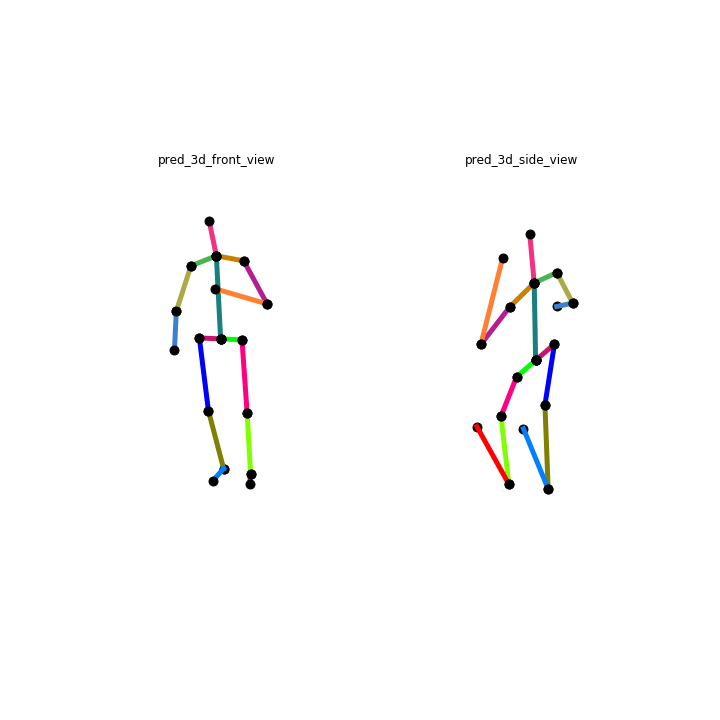

(2.4141647, -2.15919074)
(2.4141647, -2.15919074)


In [764]:
skeleton_images = skeleton_to_image(temp_pose)

In [744]:
poses_3d[46:47]

array([[[ 0.        ,  0.        ,  0.        ],
        [-0.13944102, -0.29382054,  4.73885278],
        [-1.38906734, -0.30925629,  4.17751884],
        [-2.45919074, -0.13587651,  1.59589622],
        [-2.29697341, -1.04187785, -0.62059811],
        [ 1.19570373, -0.2777172 ,  4.43221101],
        [ 2.4141647 , -0.73099479,  1.95231337],
        [ 0.61109478, -2.10934935,  2.73274759],
        [-0.34764568, -0.88397164,  6.63842444],
        [-1.0484416 , -0.00897523,  0.05647702],
        [-0.58535741, -0.0684074 , -4.11749242],
        [-0.05213199,  0.86102494, -7.55432616],
        [-0.34226863, -1.06421808, -8.01177566],
        [ 1.04844163,  0.00897524, -0.05647641],
        [ 1.43393143, -0.63399981, -4.18902777],
        [ 1.47723957, -0.0122065 , -7.73465853],
        [ 1.83417045, -1.97974096, -7.7721886 ]]])

(-0.5, 223.5, 223.5, -0.5)

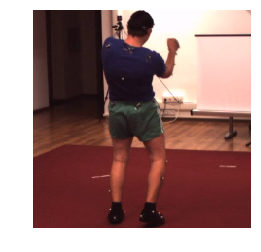

In [766]:
%matplotlib inline
image = cv2.imread('/data/vcl/sid/human36_parsed/parsed_data/center_crops/S11_Discussion 1_58860488_video_495_585_11/crop_params_206_565_474_833_57.png')
plt.imshow(image[:,:,::-1])
plt.axis('off')

<IPython.core.display.Javascript object>


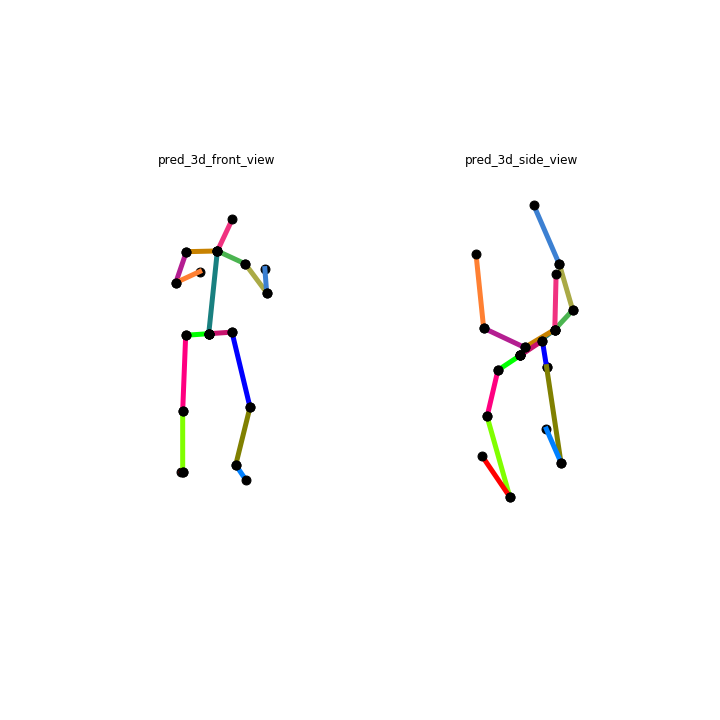

(1.5450634502313516, -2.4222692567189363)
(1.5450634502313516, -2.4222692567189363)


In [767]:
poses_3d = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/poses_3d/S11_Discussion 1_58860488.mat')['pose_3d']
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
skeleton_images = skeleton_to_image(poses_3d[552:553])

<IPython.core.display.Javascript object>


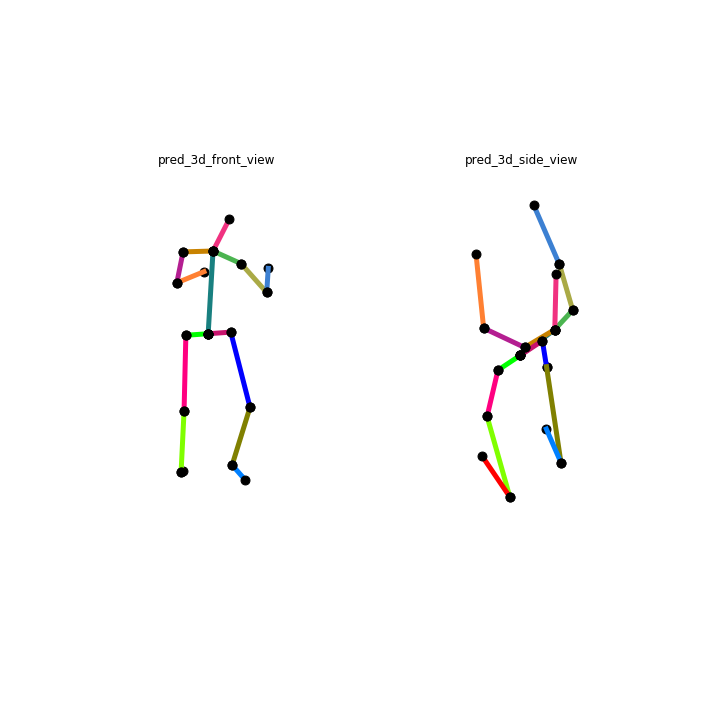

(1.5450634502313516, -2.4222692567189363)
(1.5450634502313516, -2.4222692567189363)


In [769]:
skeleton_images = skeleton_to_image(poses_3d[552:553])

(-0.5, 223.5, 223.5, -0.5)

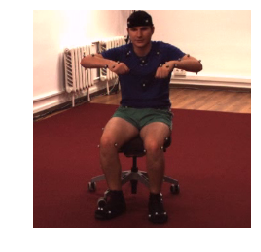

In [771]:
%matplotlib inline
image = cv2.imread('/data/vcl/sid/human36_parsed/parsed_data/center_crops/S11_Eating 1_55011271_video_45_135_1/crop_params_316_651_408_743_79.png')
plt.imshow(image[:,:,::-1])
plt.axis('off')

<IPython.core.display.Javascript object>


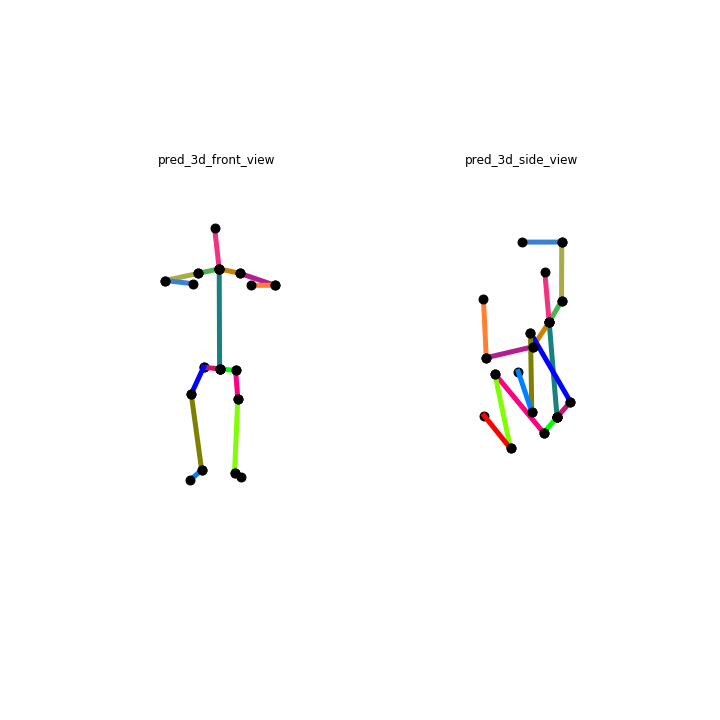

(3.9036439864549104, -2.7479264236701337)
(3.9036439864549104, -2.7479264236701337)


In [772]:
poses_3d = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/poses_3d/S11_Eating 1_55011271.mat')['pose_3d']
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
skeleton_images = skeleton_to_image(poses_3d[124:125])

<IPython.core.display.Javascript object>


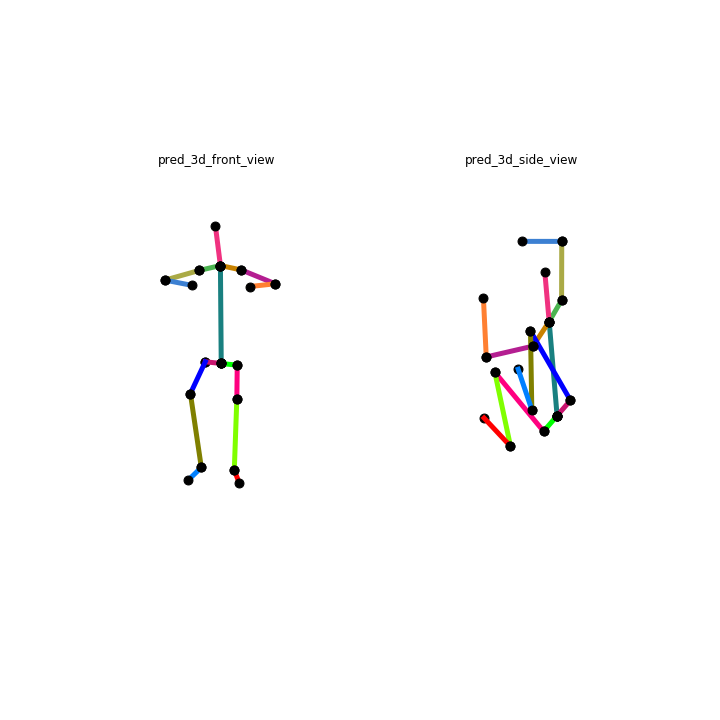

(3.90364399, -2.74792642)
(3.90364399, -2.74792642)


In [782]:
skeleton_images = skeleton_to_image(temp_pose)

In [775]:
poses_3d[124:125]

array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.12089581, -0.70065349,  4.69648474],
        [-1.13070633, -1.21048554,  4.47184419],
        [-2.74792642, -3.45702406,  4.05034233],
        [-0.67260965, -4.64426421,  3.84172521],
        [ 1.44916812, -0.43987074,  4.48533311],
        [ 3.90364399, -1.6373205 ,  3.86754488],
        [ 2.74711142, -3.73867897,  3.78553859],
        [-0.03596197, -1.38943025,  6.56757592],
        [-1.04234944, -0.10200854,  0.07484587],
        [-0.924873  , -4.13635293, -1.08716299],
        [-0.45566681, -3.29382447, -4.55559078],
        [-0.74306982, -5.24909473, -4.86270265],
        [ 1.04234941,  0.10200866, -0.07484613],
        [ 1.9384084 , -3.81343649, -1.30218778],
        [ 1.52133953, -2.73400431, -4.71112893],
        [ 2.27581774, -4.58621635, -4.71968411]]])

(-0.5, 223.5, 223.5, -0.5)

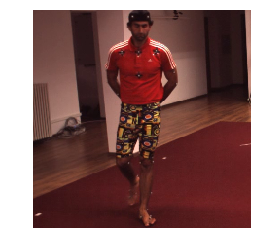

In [786]:
%matplotlib inline
image = cv2.imread('/data/vcl/sid/human36_parsed/parsed_data/center_crops/S9_Walking_58860488_video_450_540_10/crop_params_191_677_58_544_60.png')
plt.imshow(image[:,:,::-1])
plt.axis('off')

<IPython.core.display.Javascript object>


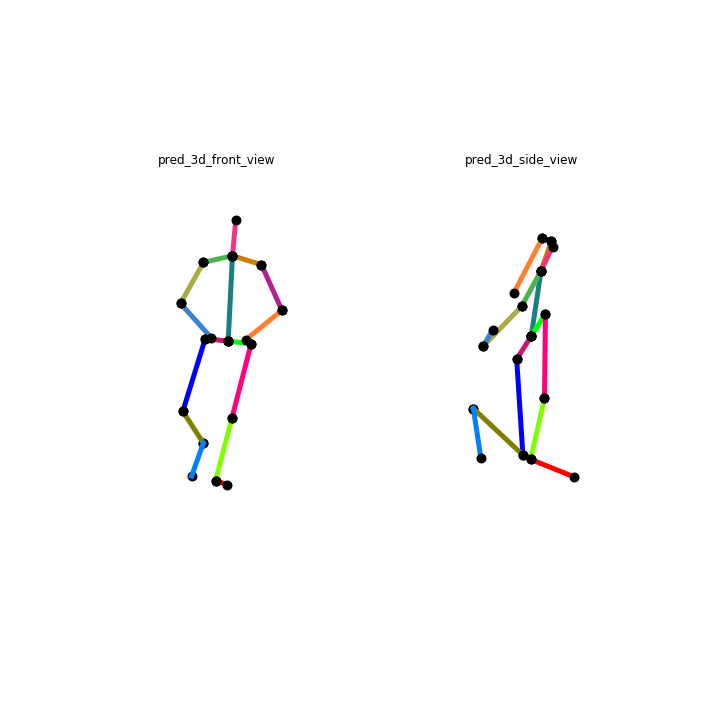

(2.503621977062135, -1.739772352207323)
(2.503621977062135, -1.739772352207323)


In [787]:
poses_3d = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/poses_3d/S9_Walking_58860488.mat')['pose_3d']
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
skeleton_images = skeleton_to_image(poses_3d[510:511])

<IPython.core.display.Javascript object>


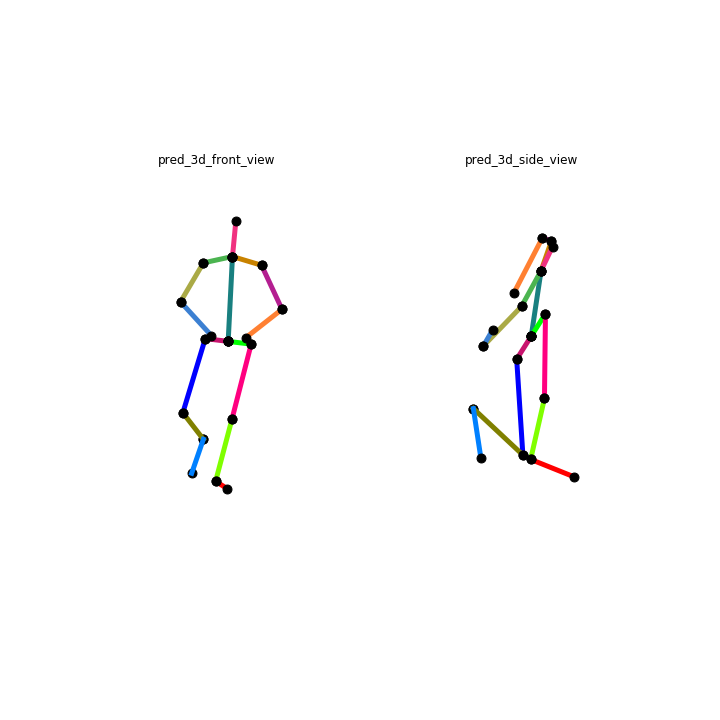

(2.503621977062135, -1.739772352207323)
(2.503621977062135, -1.739772352207323)


In [789]:
skeleton_images = skeleton_to_image(poses_3d[510:511])

<IPython.core.display.Javascript object>


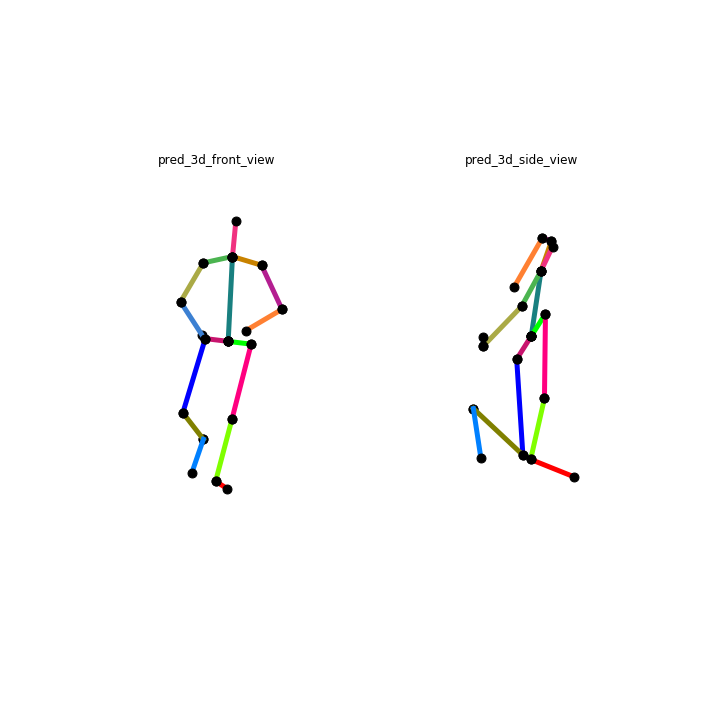

(2.50362198, -1.73977235)
(2.50362198, -1.73977235)


In [800]:
skeleton_images = skeleton_to_image(temp_pose)

In [790]:
poses_3d[510:511]

array([[[ 0.        ,  0.        ,  0.        ],
        [-0.36151349,  0.21742266,  4.7312298 ],
        [ 0.90109307,  0.61427619,  4.37734852],
        [ 2.50362198,  0.05562151,  2.15028632],
        [ 1.46080962, -0.88135027,  0.20230627],
        [-1.40035476, -0.53123158,  4.24417164],
        [-1.73977235, -1.74817432,  1.74540273],
        [-0.01860081, -1.46034604,  0.09776097],
        [-0.73700744,  0.54040883,  6.66893055],
        [ 0.98219398,  0.34301116,  0.14190955],
        [ 1.39703249,  1.48940876, -3.87725474],
        [ 2.2256308 , -1.38083214, -5.88602103],
        [ 2.33139813, -0.5800179 , -7.71564116],
        [-0.98219407, -0.3430111 , -0.14190911],
        [-0.45317149,  0.40100483, -4.24149146],
        [ 0.34090007,  0.49155886, -7.75165532],
        [-1.12461523,  1.85213203, -7.71840585]]])

(-0.5, 223.5, 223.5, -0.5)

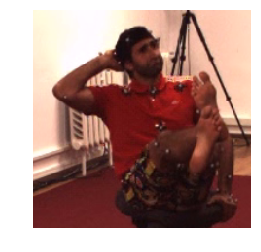

In [807]:
%matplotlib inline
image = cv2.imread('/data/vcl/sid/human36_parsed/parsed_data/center_crops/S9_Sitting_55011271_video_630_720_14/crop_params_315_505_411_601_10.png')
plt.imshow(image[:,:,::-1])
plt.axis('off')

<IPython.core.display.Javascript object>


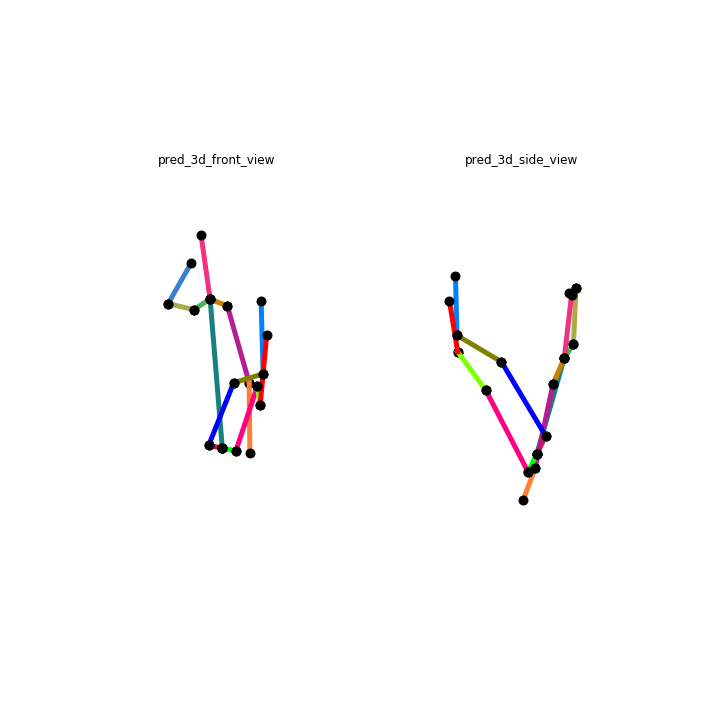

(4.128606764562608, -3.8760180287709436)
(4.128606764562608, -3.8760180287709436)


In [803]:
poses_3d = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/poses_3d/S9_Sitting_55011271.mat')['pose_3d']
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
skeleton_images = skeleton_to_image(poses_3d[640:641])

(4.81059966, -3.87601803)
(4.81059966, -3.87601803)


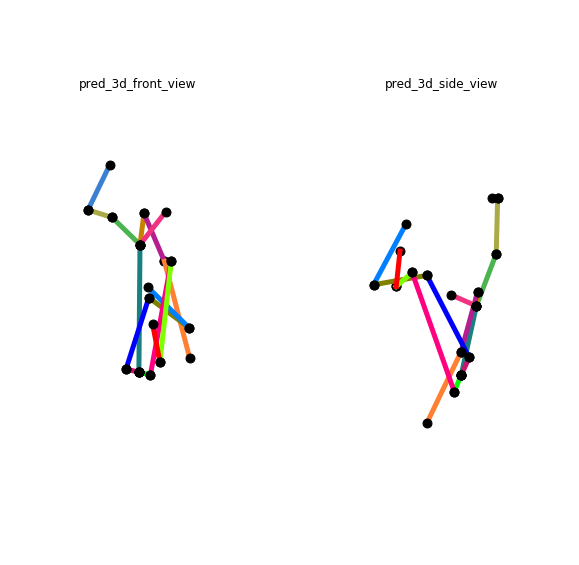

In [847]:
skeleton_images = skeleton_to_image(temp_pose)

In [836]:
poses_3d[640:641]

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.23012625e+00,  1.90410114e+00,  4.17416917e+00],
        [-2.37782191e+00,  1.21163834e+00,  3.89099088e+00],
        [-3.87601803e+00, -1.13654680e+00,  4.17635893e+00],
        [-2.41496386e+00,  4.14146822e-01,  5.28119828e+00],
        [ 3.86195957e-03,  2.45965185e+00,  3.96077630e+00],
        [ 1.62647601e+00,  2.82280587e+00,  1.70794635e+00],
        [ 1.87892708e+00,  1.41492710e+00, -2.19265574e-01],
        [-1.88938679e+00,  1.69377692e+00,  6.05063906e+00],
        [-9.63736437e-01, -4.05038813e-01,  9.82631162e-02],
        [ 1.33277927e+00, -3.27368259e+00,  2.13219981e+00],
        [ 3.81059966e+00, -5.84320351e+00,  2.59907063e+00],
        [ 3.70112467e+00, -6.15412464e+00,  4.57171943e+00],
        [ 9.63736364e-01,  4.05039050e-01, -9.82628592e-02],
        [ 2.97720671e+00, -2.61432665e+00,  2.01582510e+00],
        [ 3.64065892e+00, -6.14374052e+00,  1.76468989e+00],
        [ 4.12860676e+00

In [846]:
temp_pose = np.array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-0.23012625e+00,  1.90410114e+00,  3.17416917e+00],
        [-2.37782191e+00,  1.21163834e+00,  3.89099088e+00],
        [-3.87601803e+00, -1.13654680e+00,  4.17635893e+00],
        [-2.41496386e+00,  4.14146822e-01,  5.28119828e+00],
        [ 3.86195957e-03,  2.45965185e+00,  3.96077630e+00],
        [ 1.62647601e+00,  2.82280587e+00,  2.70794635e+00],
        [ 3.87892708e+00,  1.41492710e+00,  3.19265574e-01],
        [1.88938679e+00,  1.69377692e+00,  4.05063906e+00],
        [-9.63736437e-01, -4.05038813e-01,  9.82631162e-02],
        [ 1.33277927e+00, -3.27368259e+00,  2.13219981e+00],
        [ 4.81059966e+00, -5.84320351e+00,  1.59907063e+00],
        [ 1.70112467e+00, -6.15412464e+00,  2.57171943e+00],
        [ 8.63736364e-01,  4.05039050e-01, -8.82628592e-02],
        [ 2.97720671e+00, -2.61432665e+00,  3.01582510e+00],
        [ 2.64065892e+00, -6.14374052e+00,  0.76468989e+00],
        [ 2.12860676e+00, -6.40194681e+00,  1.68698966e+00]]])

(-0.5, 223.5, 223.5, -0.5)

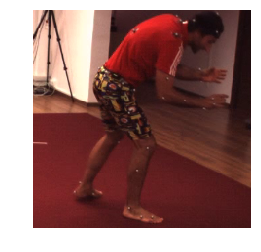

In [848]:
%matplotlib inline
image = cv2.imread('/data/vcl/sid/human36_parsed/parsed_data/center_crops/S9_Photo 1_60457274_video_540_630_12/crop_params_251_578_478_805_51.png')
plt.imshow(image[:,:,::-1])
plt.axis('off')

<IPython.core.display.Javascript object>


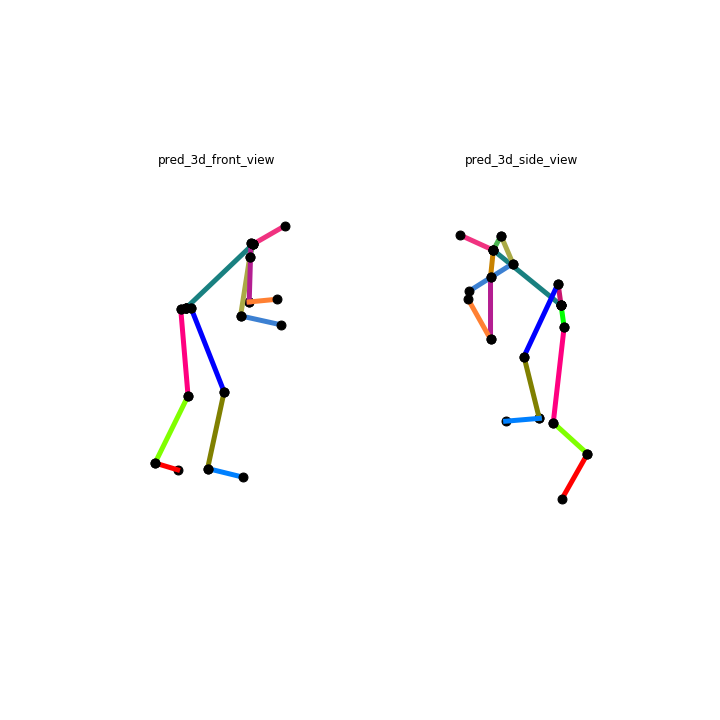

(4.257344190587958, -0.6200551914736792)
(4.257344190587958, -0.6200551914736792)


In [850]:
poses_3d = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/poses_3d/S9_Photo 1_60457274.mat')['pose_3d']
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
skeleton_images = skeleton_to_image(poses_3d[591:592])

<IPython.core.display.Javascript object>


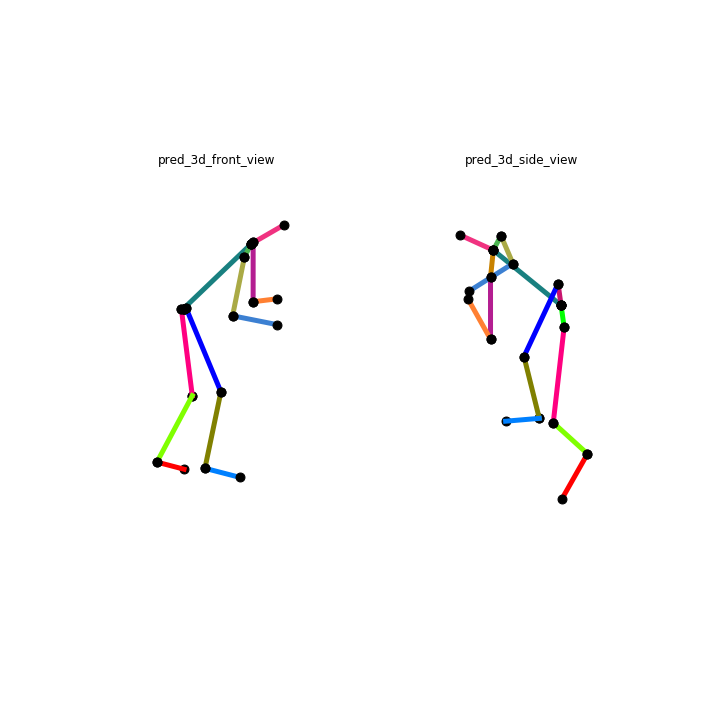

(4.257344190587958, -0.6200551914736792)
(4.257344190587958, -0.6200551914736792)


In [852]:
skeleton_images = skeleton_to_image(poses_3d[591:592])

(-0.5, 223.5, 223.5, -0.5)

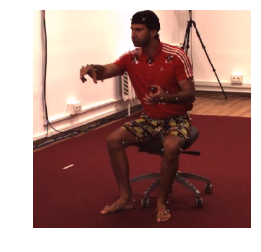

In [854]:
%matplotlib inline
image = cv2.imread('/data/vcl/sid/human36_parsed/parsed_data/center_crops/S9_Eating 1_55011271_video_585_675_13/crop_params_302_626_312_636_84.png')
plt.imshow(image[:,:,::-1])
plt.axis('off')

<IPython.core.display.Javascript object>


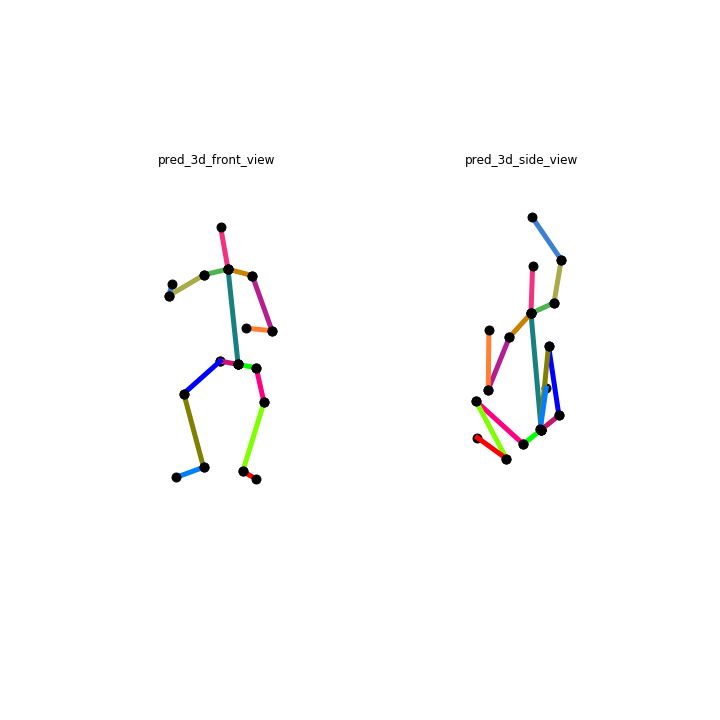

(2.162106341303195, -3.245401367627787)
(2.162106341303195, -3.245401367627787)


In [855]:
poses_3d = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/poses_3d/S9_Eating 1_55011271.mat')['pose_3d']
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
skeleton_images = skeleton_to_image(poses_3d[669:670])

<IPython.core.display.Javascript object>


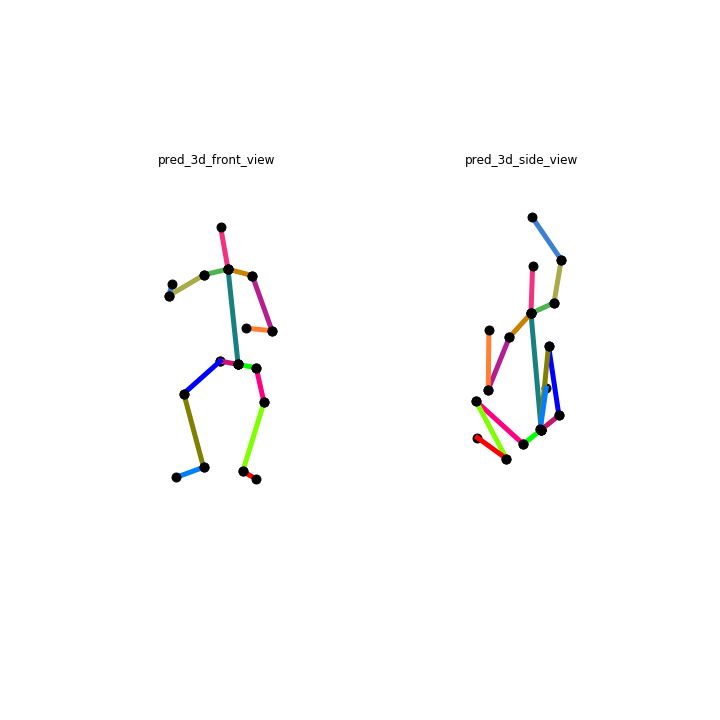

(2.162106341303195, -3.245401367627787)
(2.162106341303195, -3.245401367627787)


In [868]:
skeleton_images = skeleton_to_image(poses_3d[669:670])

<IPython.core.display.Javascript object>


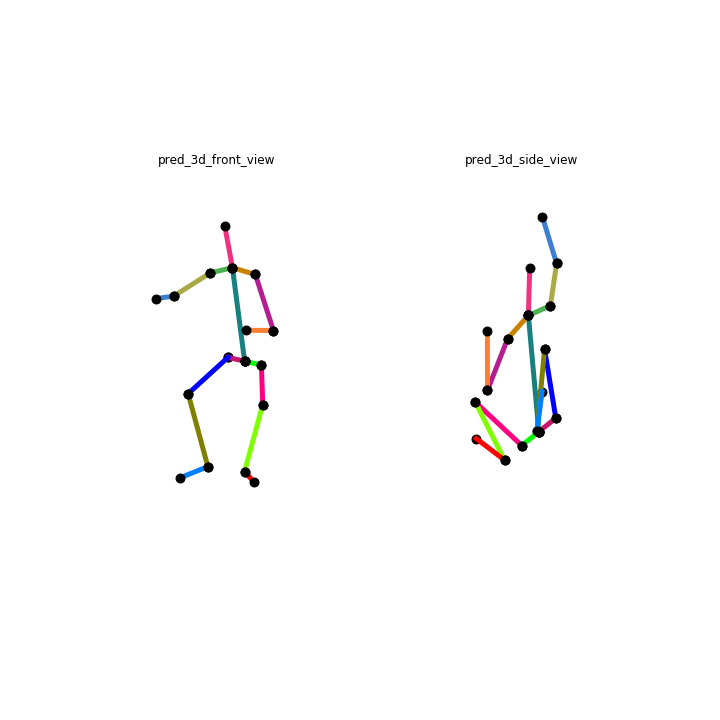

(2.16210634, -3.60185297)
(2.16210634, -3.60185297)


In [870]:
skeleton_images = skeleton_to_image(temp_pose)

In [858]:
poses_3d[669:670]

array([[[ 0.        ,  0.        ,  0.        ],
        [-0.3005468 , -1.73833241,  4.4102576 ],
        [-1.64376656, -1.61843254,  4.16883534],
        [-3.24540137, -3.66899292,  3.13444273],
        [-2.60185297, -5.93817316,  3.5779137 ],
        [ 1.03367267, -1.68270945,  4.10421106],
        [ 2.16210634, -1.99194108,  1.56039243],
        [ 1.04098467, -4.11199189,  1.65242897],
        [-0.63945109, -2.19626915,  6.32740074],
        [-1.03336093,  0.10124206,  0.15625375],
        [-2.4264199 , -3.58446916, -1.29802255],
        [-1.48268733, -2.79430693, -4.68107036],
        [-2.70528617, -4.33375494, -5.0489724 ],
        [ 1.03336099, -0.10124201, -0.15625335],
        [ 1.97605627, -3.90593967, -1.66476298],
        [ 0.67418649, -2.81459705, -4.83873625],
        [ 1.61725253, -4.56786849, -5.03021912]]])

In [865]:
temp_pose = np.array([[[ 0.        ,  0.        ,  0.        ],
        [-0.3005468 , -1.73833241,  4.4102576 ],
        [-1.64376656, -1.61843254,  4.16883534],
        [-3.24540137, -3.66899292,  3.13444273],
        [-3.60185297, -5.93817316,  3.0779137 ],
        [ 1.03367267, -1.68270945,  4.10421106],
        [ 2.16210634, -1.99194108,  1.56039243],
        [ 1.04098467, -4.11199189,  1.65242897],
        [-0.63945109, -2.19626915,  6.32740074],
        [-1.03336093,  0.10124206,  0.15625375],
        [-2.4264199 , -3.58446916, -1.29802255],
        [-1.48268733, -2.79430693, -4.68107036],
        [-2.70528617, -4.33375494, -5.0489724 ],
        [ 1.03336099, -0.10124201, -0.15625335],
        [ 1.97605627, -3.90593967, -1.66476298],
        [ 0.67418649, -2.81459705, -4.83873625],
        [ 1.61725253, -4.56786849, -5.03021912]]])

(-0.5, 999.5, 999.5, -0.5)

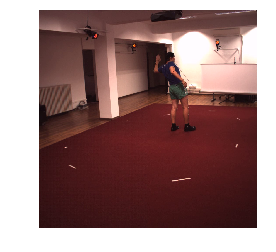

In [4]:
%matplotlib inline
image = cv2.imread('/data/vcl/sid/human36_parsed/parsed_data/extracted_frames/S11_Waiting 1_58860488/862.png')
plt.imshow(image[:,:,::-1])
plt.axis('off')

<IPython.core.display.Javascript object>


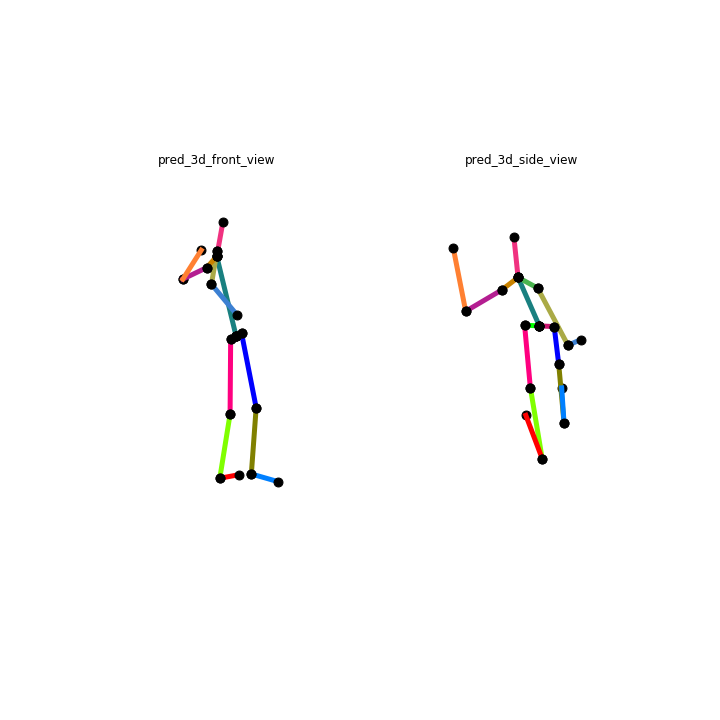

(5.615313288732824, -2.909932040219898)
(5.615313288732824, -2.909932040219898)


In [9]:
poses_3d = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/poses_3d/S11_Waiting 1_58860488.mat')['pose_3d']
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
skeleton_images = skeleton_to_image(poses_3d[862:863])

<IPython.core.display.Javascript object>


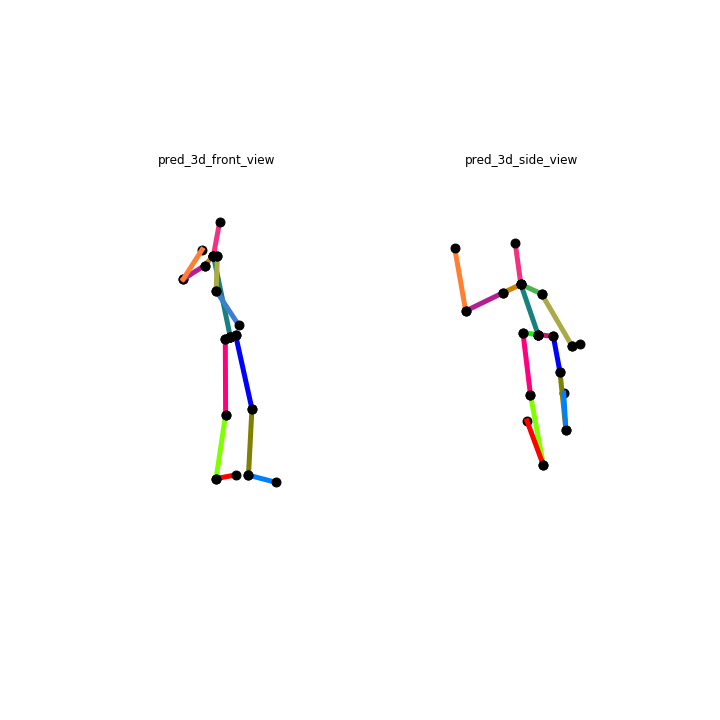

(5.2269198460312065, -3.16376908164963)
(5.2269198460312065, -3.16376908164963)


In [13]:
poses_3d = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/poses_3d/S11_Waiting 1_58860488.mat')['pose_3d']
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
skeleton_images = skeleton_to_image(poses_3d[873:874])

In [14]:
poses_3d[873:874]

array([[[ 0.        ,  0.        ,  0.        ],
        [ 1.49017276, -0.01309977,  4.51017888],
        [ 0.43440838,  0.85984702,  4.5251952 ],
        [-0.81584204,  2.52891809,  2.65675317],
        [-2.14082916,  1.80459162,  0.7913416 ],
        [ 2.65578517, -0.47131803,  3.95494585],
        [ 5.22691985, -1.23236368,  3.14867293],
        [ 4.89323564, -2.89636185,  4.84565995],
        [ 1.45670082, -0.64783439,  6.40648888],
        [-0.88136451,  0.54720959,  0.16204401],
        [-1.91173102,  0.0824117 , -3.88299094],
        [-2.0357838 ,  0.62598604, -7.43955359],
        [-3.16376908, -0.92999201, -7.99325164],
        [ 0.8813645 , -0.54720947, -0.16204451],
        [ 0.53524221, -0.15181526, -4.32904136],
        [ 0.36983233,  1.07838292, -7.70827974],
        [ 0.22947444, -0.91510271, -7.78774481]]])

(-0.5, 999.5, 1001.5, -0.5)

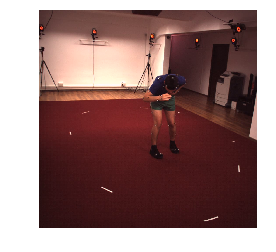

In [4]:
%matplotlib inline
image = cv2.imread('/data/vcl/sid/human36_parsed/parsed_data/extracted_frames/S11_Greeting 2_60457274/922.png')
plt.imshow(image[:,:,::-1])
plt.axis('off')

<IPython.core.display.Javascript object>


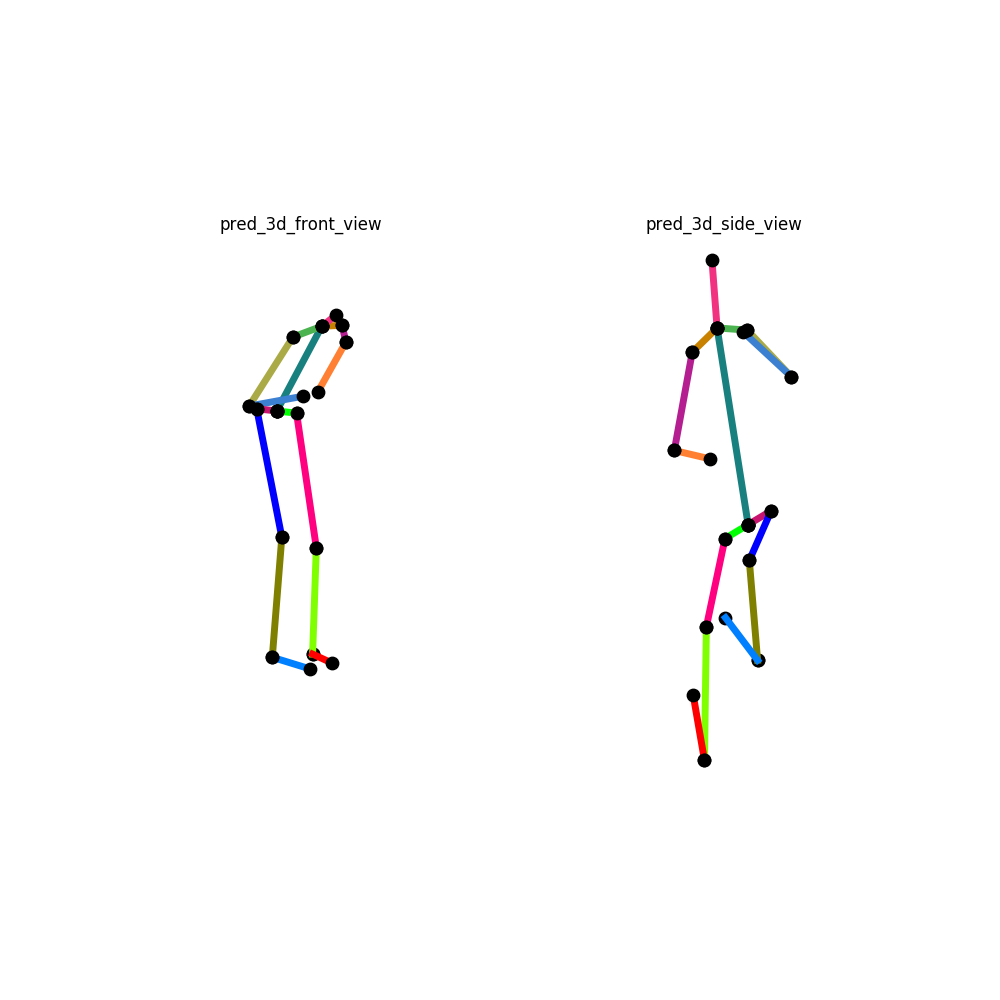

(2.4483156709158944, -3.9862132421005434)
(2.4483156709158944, -3.9862132421005434)


In [7]:
poses_3d = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/poses_3d/S11_Greeting 2_60457274.mat')['pose_3d']
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
skeleton_images = skeleton_to_image(poses_3d[922:923])

<IPython.core.display.Javascript object>


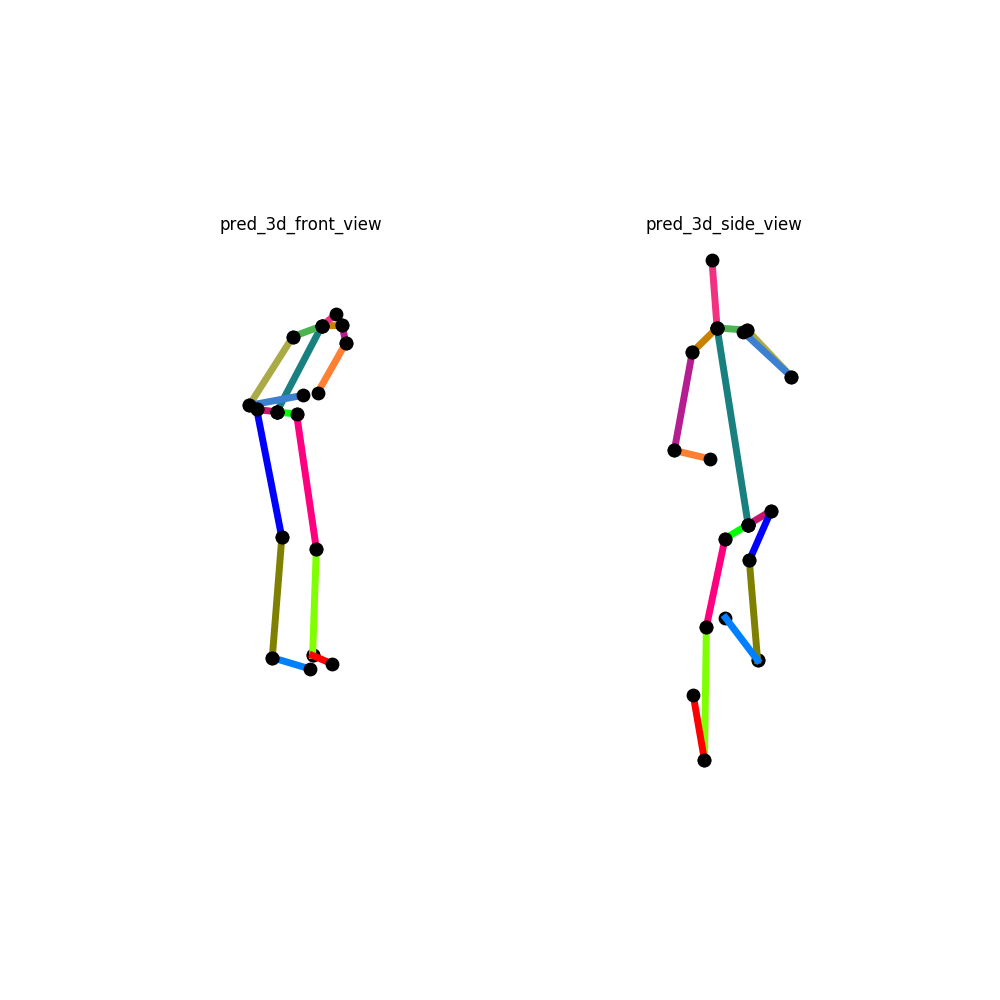

(2.4483156709158944, -3.9862132421005434)
(2.4483156709158944, -3.9862132421005434)


In [10]:
poses_3d = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/poses_3d/S11_Greeting 2_60457274.mat')['pose_3d']
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
skeleton_images = skeleton_to_image(poses_3d[922:923])

<IPython.core.display.Javascript object>


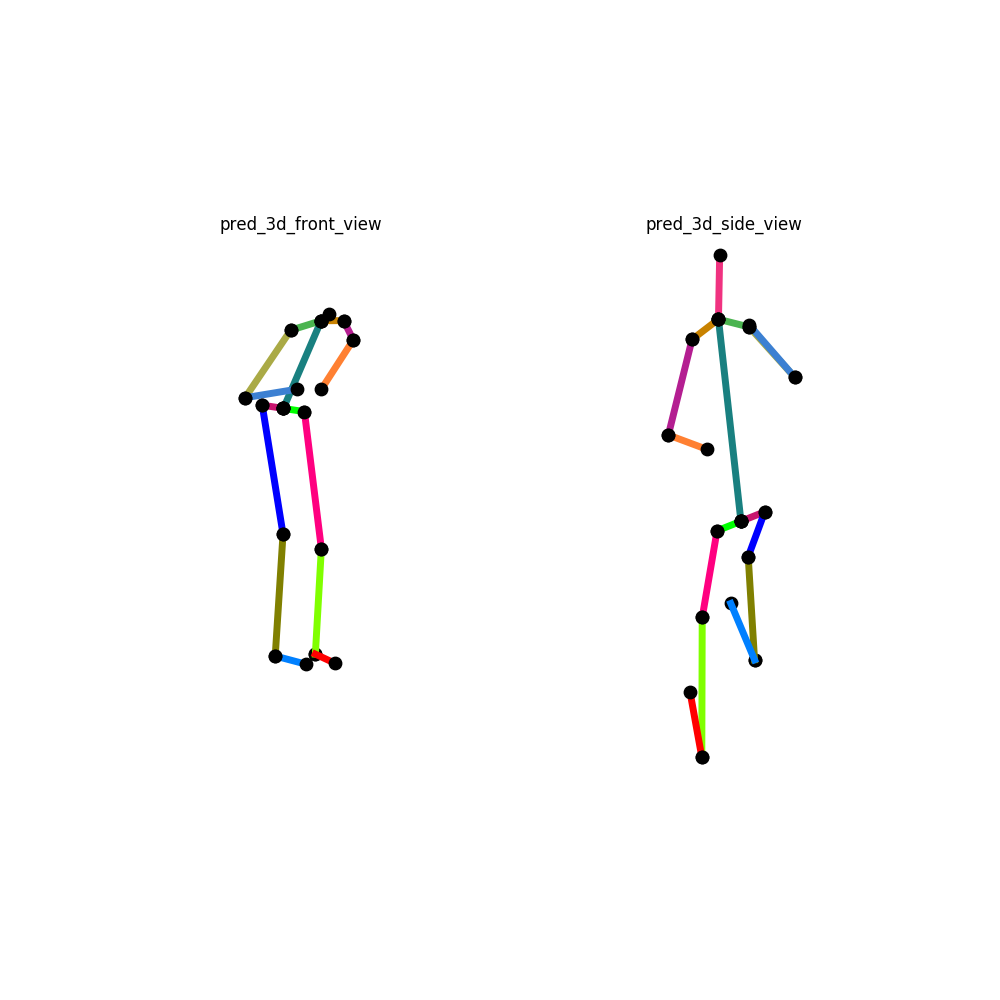

(2.2478414680640078, -4.334761974761934)
(2.2478414680640078, -4.334761974761934)


In [12]:
poses_3d = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/poses_3d/S11_Greeting 2_60457274.mat')['pose_3d']
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
skeleton_images = skeleton_to_image(poses_3d[925:926])

In [13]:
poses_3d[925:926]

array([[[ 0.        ,  0.        ,  0.        ],
        [-1.31922701, -3.89395361,  2.37892105],
        [-2.50527791, -3.26876991,  2.09726776],
        [-4.33476197, -2.40404029,  0.1620079 ],
        [-3.36203188, -4.58910774,  0.36019064],
        [ 0.04893634, -3.85389164,  2.43743697],
        [ 2.24784147, -2.16963087,  2.02745907],
        [ 0.38062649, -2.08805048,  0.52185192],
        [-2.42329763, -5.56038276,  2.44249737],
        [-1.00290232,  0.29907173,  0.08510602],
        [-1.30327398, -1.43141213, -3.73002209],
        [-1.39327051, -1.01620317, -7.30486504],
        [-1.40076904, -3.01110301, -7.44740761],
        [ 1.00290232, -0.29907179, -0.08510583],
        [ 1.23182176, -1.17158291, -4.18709562],
        [ 2.09140353,  0.15230025, -7.42259443],
        [ 1.53236851, -1.76029892, -7.59418779]]])

(-0.5, 999.5, 1001.5, -0.5)

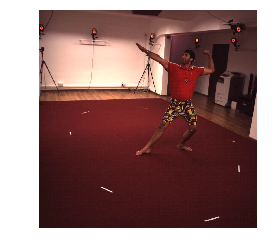

In [15]:
%matplotlib inline
image = cv2.imread('/data/vcl/sid/human36_parsed/parsed_data/extracted_frames/S9_Posing 1_60457274/1074.png')
plt.imshow(image[:,:,::-1])
plt.axis('off')

<IPython.core.display.Javascript object>


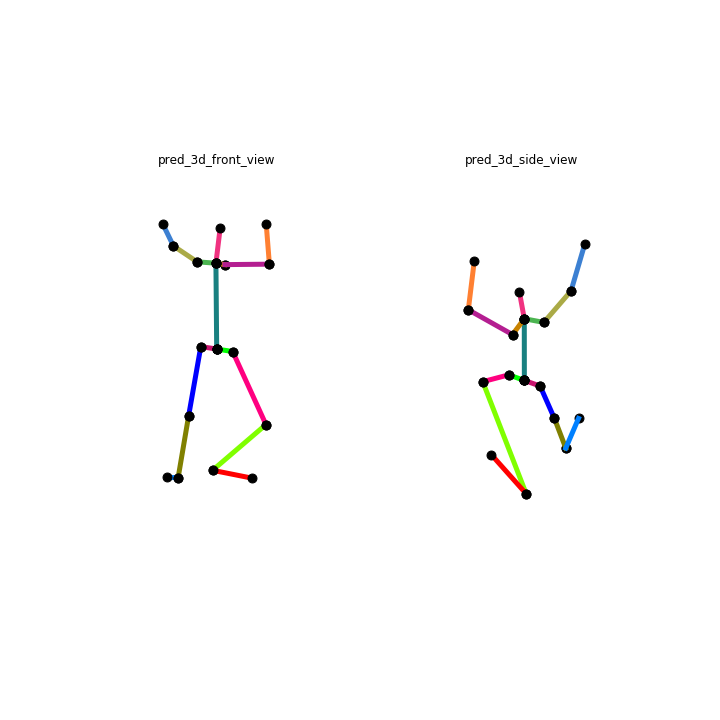

(4.14116295733266, -6.174488405837057)
(4.14116295733266, -6.174488405837057)


In [16]:
poses_3d = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/poses_3d/S9_Posing 1_60457274.mat')['pose_3d']
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
skeleton_images = skeleton_to_image(poses_3d[1074:1075])

<IPython.core.display.Javascript object>


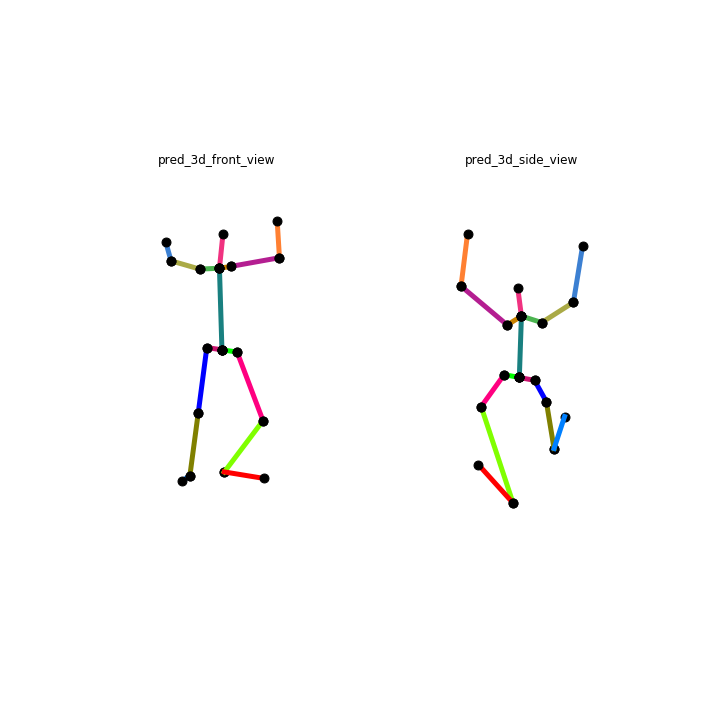

(3.701221229903738, -6.195639725884297)
(3.701221229903738, -6.195639725884297)


In [22]:
poses_3d = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/poses_3d/S9_Posing 1_60457274.mat')['pose_3d']
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
skeleton_images = skeleton_to_image(poses_3d[1055:1056])

In [23]:
poses_3d[1055:1056]

array([[[ 0.        ,  0.        ,  0.        ],
        [-0.05036149,  0.1056391 ,  4.74855811],
        [-1.34902321,  0.53932876,  4.70069354],
        [-4.10878653,  0.75170693,  5.12330671],
        [-6.19563973,  0.02899047,  6.062841  ],
        [ 1.31193637,  0.1023127 ,  4.89358734],
        [ 3.70122123, -1.28720916,  5.34141192],
        [ 2.45585761, -1.68726034,  7.35363172],
        [ 0.19708381,  0.03564498,  6.73195712],
        [-0.98682251,  0.33483414,  0.12871452],
        [-2.7925105 , -0.04377758, -3.64436699],
        [-3.36739197,  0.1168817 , -7.19453598],
        [-5.29453614, -0.39183037, -7.35984588],
        [ 0.98682258, -0.33483389, -0.12871467],
        [ 2.14930909, -1.12618959, -4.08628732],
        [ 1.42556849,  0.50759946, -7.21149657],
        [ 2.83620464, -0.88556783, -7.47453757]]])

(-0.5, 999.5, 999.5, -0.5)

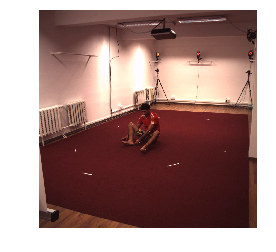

In [86]:
%matplotlib inline
image = cv2.imread('/data/vcl/sid/human36_parsed/parsed_data/extracted_frames/S9_SittingDown_55011271/700.png')
plt.imshow(image[:,:,::-1])
plt.axis('off')

<IPython.core.display.Javascript object>


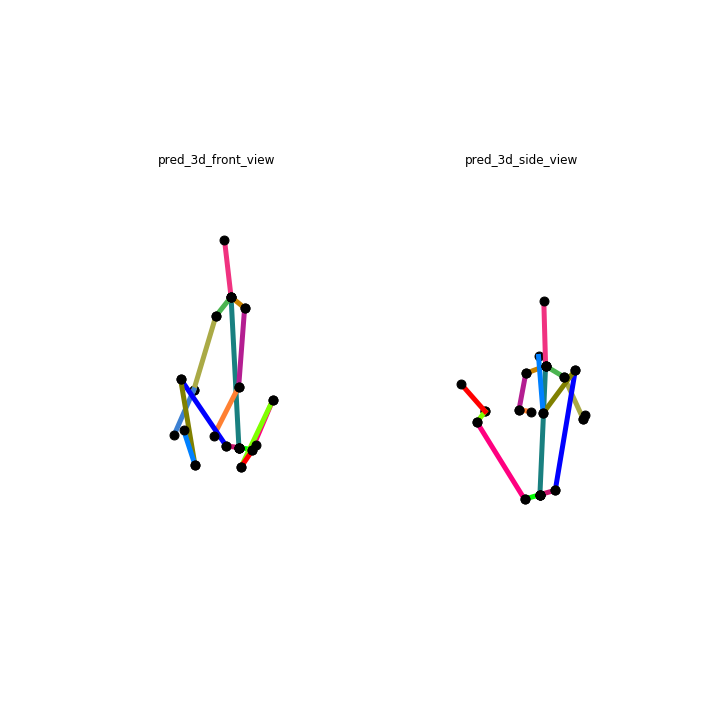

(2.847397802927381, -4.3063293842743295)
(2.847397802927381, -4.3063293842743295)


In [30]:
poses_3d = sio.loadmat('/data/vcl/sid/human36_parsed/parsed_data/poses_3d/S9_SittingDown_55011271.mat')['pose_3d']
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
skeleton_images = skeleton_to_image(poses_3d[700:701])

<IPython.core.display.Javascript object>


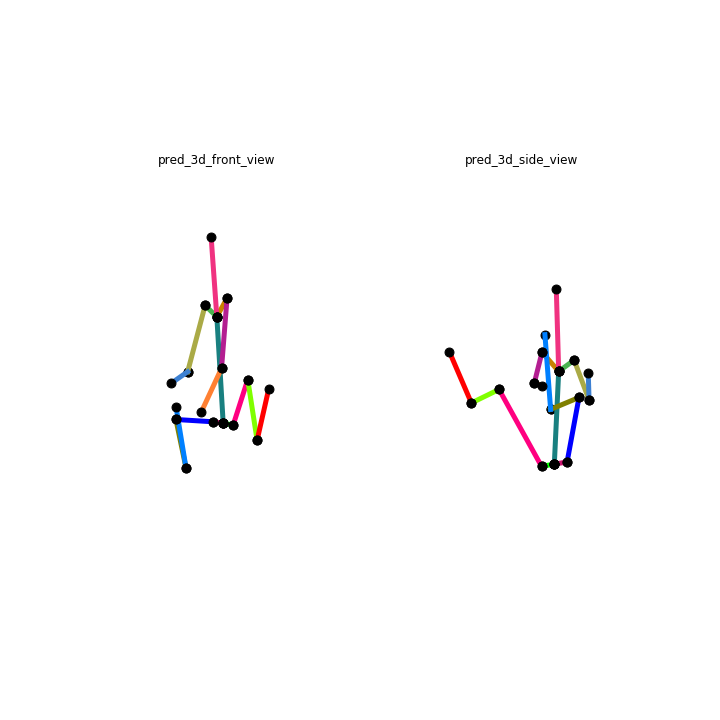

(5.25022946, -4.30632938)
(5.25022946, -4.30632938)


In [88]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
skeleton_images = skeleton_to_image(temp_pose-temp_pose[:,0:1])

In [33]:
poses_3d[700:701]

array([[[ 0.        ,  0.        ,  0.        ],
        [-0.51441024, -0.24269966,  4.7158222 ],
        [-1.65620195,  0.23208957,  4.12608761],
        [-3.21193769,  0.2063287 ,  1.79820817],
        [-4.30632938, -1.41236271,  0.40459956],
        [ 0.54572218, -1.03306502,  4.35757389],
        [ 0.33682454, -2.42055166,  1.93450918],
        [-1.18974149, -3.53213755,  0.45330258],
        [-0.83656784, -1.1279196 ,  6.48007845],
        [-0.96476625,  0.41231554,  0.0414967 ],
        [-3.76193318, -1.89099791,  2.16531503],
        [-2.38782942, -3.9882047 , -0.4180089 ],
        [-2.86918305, -5.59220022,  0.67537899],
        [ 0.96476625, -0.41231554, -0.04149665],
        [ 2.8473978 , -3.8040184 ,  1.56848787],
        [ 1.05649565, -6.24127079, -0.38406693],
        [ 2.25022946, -7.6841956 ,  0.31804957]]])

In [87]:
temp_pose = np.array([[[ 0.        ,  0.        ,  0.        ],
        [-0.51441024, -0.24269966,  3.7158222 ],
        [-1.65620195,  0.23208957,  4.12608761],
        [-3.21193769,  0.2063287 ,  1.79820817],
        [-4.30632938, -1.41236271,  1.40459956],
        [ 0.54572218, -1.03306502,  4.35757389],
        [ 0.33682454, -2.42055166,  1.93450918],
        [-1.18974149, -3.53213755,  0.45330258],
        [-0.83656784, -1.1279196 ,  6.48007845],
        [-0.96476625,  0.41231554,  0.0414967 ],
        [-3.76193318, -1.89099791,  0.16531503],
        [-2.38782942, -3.9882047 , -1.4180089 ],
        [-2.86918305, -5.59220022,  0.67537899],
        [ 0.96476625, -0.41231554, -0.04149665],
        [ 2.8473978 , -3.8040184 ,  1.56848787],
        [ 4.05649565, -6.24127079, -0.38406693],
        [ 5.25022946, -7.6841956 , 1.31804957]]])